In [1]:
# Block 1: Setup and Initialization
import numpy as np
from petsc4py import PETSc
from mpi4py import MPI
import ufl
from dolfinx import mesh, fem
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc

# Domain and Function Space Setup
nx, ny = 5, 5
domain = mesh.create_unit_square(MPI.COMM_WORLD, nx, ny, mesh.CellType.triangle)
V = fem.functionspace(domain, ("Lagrange", 1))

# Exact Solution Class
class exact_solution():
    def __init__(self, alpha, beta, t):
        self.alpha = alpha
        self.beta = beta
        self.t = t

    def __call__(self, x):
        return -np.sin(np.pi*self.alpha*x[0])*np.sin(np.pi*self.beta*x[1])* np.exp(-(self.alpha**2 + self.beta**2)*np.pi**2* self.t)

alpha, beta = 10, 1
t0, t1 = 0, 0.5
u_exact = exact_solution(alpha, beta, t0)
u_D = fem.Function(V)
u_D.interpolate(u_exact)

# Dirichlet Boundary Condition
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)
bc = fem.dirichletbc(u_D, fem.locate_dofs_topological(V, fdim, boundary_facets))

# Initial Condition
u_n = fem.Function(V)
u_n.interpolate(u_exact)
f = fem.Constant(domain, 0.0)

# Variational Form
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
dt = 0.05 / 20  # Time step size
F = u * v * ufl.dx + dt * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx - (u_n + dt * f) * v * ufl.dx
a = fem.form(ufl.lhs(F))
L = fem.form(ufl.rhs(F))

# Assembling Matrix
A = assemble_matrix(a, bcs=[bc])
A.assemble()
b = create_vector(L)


In [2]:
# Block 2: Adaptive Integrator and Predictor Setup
from adaptive.integrator import SimpsonsRulePDE
from adaptive.predictor import PredictorQPDE
from adaptive.build_models import build_value_model
from adaptive.reward_functions import RewardLog10
from sklearn.preprocessing import StandardScaler
from adaptive.experience import Experience

integrator = SimpsonsRulePDE()  
step_sizes = np.linspace(t0, t1, 11)
dim_state = 4
dim_action = len(step_sizes)
memory = 0
tol = 0.0005

reward_fun = RewardLog10(error_tol=tol, step_size_range=(step_sizes[0], step_sizes[-1]), reward_range=(0.1, 2))
scaler = StandardScaler()
scaler.scale_ = np.ones(dim_state)
scaler.mean_ = np.zeros(dim_state)
model = build_value_model(dim_state=dim_state, dim_action=dim_action, lr=0.001)
predictor = PredictorQPDE(step_sizes=step_sizes, model=model, scaler=scaler)
experience = Experience(batch_size=32)
print("Shape of scaler mean_:", scaler.mean_.shape)
print("Shape of scaler scale_:", scaler.scale_.shape)


2024-09-16 15:55:25.741117: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-16 15:55:26.829639: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-16 15:55:29.527196: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-16 15:55:37.723059: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  a = (point1[1] - point2[1]) / np.log(point1[0] / point2[0])

  b = np.exp(point2[1] / a) / point2[0]



Shape of scaler mean_: (4,)
Shape of scaler scale_: (4,)


In [3]:
# Block 3: Environment Setup
from adaptive.environments import PDEEnv
from functions import Sinusoid, HeatEquation

initial_state = np.zeros(dim_state)  # Example placeholder
step_size_range = (step_sizes[0], step_sizes[-1])  # Define step size range
max_dist=(t1-t0)

env = PDEEnv(fun=HeatEquation(),max_iterations=10000, initial_step_size=step_sizes[0],
              step_size_range=step_size_range, reward_fun=reward_fun, error_tol=tol,
              initial_state=initial_state, t0=t0,max_dist=max_dist, nodes_per_integ=4,memory=memory)



In [4]:
# Block 3: Solver Setup
uh = fem.Function(V)
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)


In [5]:
# Block 4: Choose Action Function
def choose_action(actions, eps, dim_action):
    favored = np.argmax(actions)
    if np.random.sample() < 0.5 * eps:
        return min(favored + 1, dim_action - 1)
    elif np.random.sample() < eps:
        return max(favored - 1, 0)
    else:
        return favored

In [9]:
# Block 4: Time-Stepping Loop with Backward simpson Integration
import warnings
warnings.filterwarnings('ignore')

gamma = 0  # discount factor for future rewards

for episode in range(5):
    state = env.reset(integrator)
    done = False
    eps = 0.66
    print(f'Episode: {episode}')

    while not done:
        actions = predictor.get_actions(state)
        action = choose_action(actions, eps, dim_action)
        step_size = predictor.action_to_stepsize(action)

        # Update Dirichlet Boundary Condition
        u_exact.t += step_size
        u_D.interpolate(u_exact)

        # Update RHS
        with b.localForm() as loc_b:
            loc_b.set(0)
        assemble_vector(b, L)
        apply_lifting(b, [a], [[bc]])
        b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b, [bc])

        # Solve Linear Problem
        solver.solve(b, uh.vector)
        uh.x.scatter_forward()

        # Update State and Reward using simpson
        next_state, reward, done, _ = env.iterate(step_size, integrator)
        action_next_state = predictor.get_actions(next_state)
        target = reward + gamma * np.max(action_next_state)
        target_actions = actions.squeeze()
        target_actions[action] = target
        experience.append(state=state[0], target=target_actions)

        if experience.is_full() or done:
            states, targets = experience.get_samples()
            loss_predictor = predictor.train_on_batch(states, targets)
            experience.reset()

        state = next_state.copy()
        u_n.x.array[:] = uh.x.array


Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4


In [10]:
# Block 6: Error Computation
V_ex = fem.functionspace(domain, ("Lagrange", 2))
u_ex = fem.Function(V_ex)
u_ex.interpolate(u_exact)
error_L2 = np.sqrt(domain.comm.allreduce(fem.assemble_scalar(fem.form((uh - u_ex)**2 * ufl.dx)), op=MPI.SUM))
if domain.comm.rank == 0:
    print(f"L2-error: {error_L2:.2e}")

from dolfinx.fem import form, assemble_scalar
from ufl import dot, grad, dx
eh = uh - u_ex
comm = uh.function_space.mesh.comm
error_H10 = form(dot(grad(eh), grad(eh)) * dx)
E_H10 = np.sqrt(comm.allreduce(assemble_scalar(error_H10), op=MPI.SUM))
if comm.rank == 0:
    print(f"H01-error: {E_H10:.2e}")


L2-error: 3.47e-60
H01-error: 1.62e-59


[ 8.00000000e-01  1.00000000e+00  1.00000000e+00  8.00000000e-01
  6.00000000e-01  1.00000000e+00  6.00000000e-01  8.00000000e-01
  4.00000000e-01  1.00000000e+00  4.00000000e-01  6.00000000e-01
  8.00000000e-01  2.00000000e-01  1.00000000e+00  2.00000000e-01
  4.00000000e-01  6.00000000e-01  8.00000000e-01  4.30845614e-18
  1.00000000e+00  4.30845614e-18  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  4.30845614e-18  2.00000000e-01
  4.00000000e-01  6.00000000e-01  4.30845614e-18  2.00000000e-01
  4.00000000e-01  4.30845614e-18  2.00000000e-01 -4.30845614e-18]
[-4.30845614e-18 -4.30845614e-18  2.00000000e-01  2.00000000e-01
 -4.30845614e-18  4.00000000e-01  2.00000000e-01  4.00000000e-01
 -4.30845614e-18  6.00000000e-01  2.00000000e-01  4.00000000e-01
  6.00000000e-01 -4.30845614e-18  8.00000000e-01  2.00000000e-01
  4.00000000e-01  6.00000000e-01  8.00000000e-01  4.30845614e-18
  1.00000000e+00  2.00000000e-01  4.00000000e-01  6.00000000e-01
  8.00000000e-01  1.0000

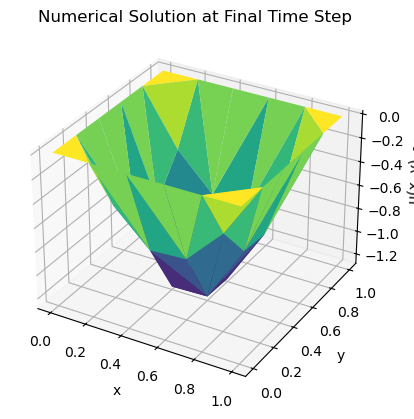

In [8]:
# Plot 1: Solution at Final Time Step
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

# Extract the solution values
x = V.tabulate_dof_coordinates()[:, 0]
y = V.tabulate_dof_coordinates()[:, 1]
z = uh.x.array
print(x)
print(y)
print(z)

# Create a 3D plot of the solution
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(x, y, z, cmap=cm.viridis)

ax.set_title("Numerical Solution at Final Time Step")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u(x, y)")

plt.show()